# Agent Chat with Huggingface Models

## Set up the environment

In [1]:
%pip install huggingface_hub Pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import re

import PIL

import autogen
from autogen import AssistantAgent, GroupChat, GroupChatManager, UserProxyAgent
from autogen.agentchat.agent import Agent
from autogen.agentchat.contrib.huggingface_agent import HuggingFaceAgent
from autogen.agentchat.contrib.img_utils import get_pil_image

In [3]:
os.environ["HUGGINGFACE_API_KEY"] = "<YOUR_HF_TOKEN>"

In [4]:
gpt4_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4"]},
)

gpt4v_config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={"model": ["gpt-4-turbo-vision"]},
)

hf_config = {
    "api_key": os.environ.get("HUGGINGFACE_API_KEY"),
    "params": {
        "timeout": 60,
    },
}

## Helper Functions

Here is a helper function to extract image from the last message of a HuggingFaceAgent.

In [5]:
def extract_img(agent: Agent) -> PIL.Image:
    last_message = agent.last_message()["content"]

    if isinstance(last_message, str):
        img_data = re.findall("<img (.*)>", last_message)[0]
    elif isinstance(last_message, list):
        # The GPT-4V format, where the content is an array of data
        for item in last_message:
            if "image_url" in item:
                img_data = item["image_url"]["url"]
                break

    pil_img = get_pil_image(img_data)
    return pil_img

## Simple Example: Call directly from User

In [6]:
assistant = HuggingFaceAgent(
    name="multimodal_assistant",
    llm_config={"config_list": gpt4v_config_list},
    hf_config={"api_key": os.environ.get("HUGGINGFACE_API_KEY")},
    is_gpt4v_format=True,
)

user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    default_auto_reply="",
    is_termination_msg=lambda x: True,
)

### Text-To-Image

In [7]:
user_proxy.initiate_chat(
    assistant, message="Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'."
)

user_proxy (to multimodal_assistant):

Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION text-to-image...
multimodal_assistant (to user_proxy):

Here is the image of a happy robot on a black background, holding a sign that reads 'I Love AutoGen':

<image>

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': "Create an image with black background, a happy robot is showing a sign with 'I Love AutoGen'.", 'role': 'assistant'}, {'content': [{'type': 'text', 'text': "Here is the image of a happy robot on a black background, holding a sign that reads 'I Love AutoGen':\n\n"}, {'type': 'image_url', 'image_url': {'url': <PIL.Image.Image image mode=RGB size=512x512 at 0x7DC2165625C0>}}, {'type': 'text', 'text': ''}], 'role': 'user'}], summary="Here is the image of a happy robot on a black background, holding a sign that reads 'I Love AutoGen':\n\n\n", cost={'usage_including_cached_inference': {'total_cost': 0}, 'usage_excluding_cached_inference': {'total_cost': 0}}, human_input=[])

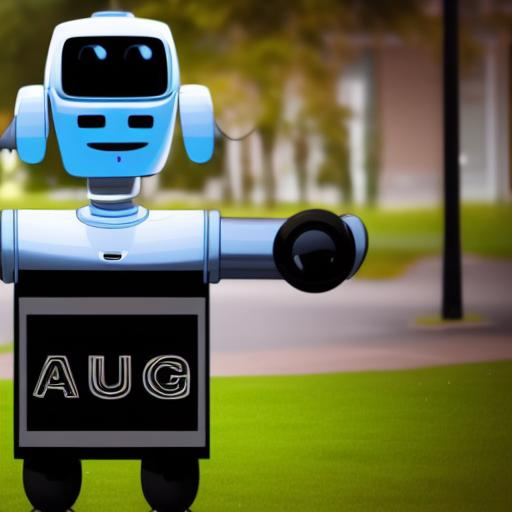

In [8]:
img = extract_img(assistant)

img.show()

### Image-To-Text

In [9]:
user_proxy.initiate_chat(
    assistant,
    message="""Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

user_proxy (to multimodal_assistant):

Write a poet for my image:
    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...

>>>>>>>> EXECUTING FUNCTION image-to-text...
multimodal_assistant (to user_proxy):

**A Moment of Serenity**

In the quiet nook, amidst the humble abode,  
Lies a small brown dog, in her comfort mode.  
Restful eyes, the softest guise,  
Floors unfurl where calmness lies.

Coat of chestnut, whispers of white,  
She dreams of fields in golden light.  
No bark, no worry, no race to chase,  
Just tender breaths, a serene embrace.

Part of the earth, part of the room,  
In gentle repose, dispelling all gloom.  
Fur as a meadow, warm and deep,  
Here she lies, in peaceful sleep.

In her silence, a story told,  
Of loyalty and love, yet to unfold.  
A companion, a friend, in simplest pleasure,  
Each moment wi

ChatResult(chat_id=None, chat_history=[{'content': 'Write a poet for my image:\n    <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.', 'role': 'assistant'}, {'content': [{'type': 'text', 'text': '**A Moment of Serenity**\n\nIn the quiet nook, amidst the humble abode,  \nLies a small brown dog, in her comfort mode.  \nRestful eyes, the softest guise,  \nFloors unfurl where calmness lies.\n\nCoat of chestnut, whispers of white,  \nShe dreams of fields in golden light.  \nNo bark, no worry, no race to chase,  \nJust tender breaths, a serene embrace.\n\nPart of the earth, part of the room,  \nIn gentle repose, dispelling all gloom.  \nFur as a meadow, warm and deep,  \nHere she lies, in peaceful sleep.\n\nIn her silence, a story told,  \nOf loyalty and love, yet to unfold.  \nA companion, a friend, in simplest pleasure,  \nEach moment with her, a timeless treasure.'}], 'role': 'user'}], summary='**A Moment of Serenity**\n\nIn the quiet